In [1]:
# import packages
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.stats as sms
import statsmodels.stats.api as smss
from scipy import stats
import numpy as np
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
warnings.filterwarnings('ignore')

C:\Users\zblack\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(y_scores,p, r, thresholds, t= 0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    
    # plot the curve
    sns.set()
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0.0, 1.00])
    plt.xlim([0.0, 1.00])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)



In [3]:
# import data
df = pd.read_csv('BGVSpringboardData.csv')

In [4]:
#Set TourID to index
df= df.set_index('TourID_dimension')

# create dictionary to change binary categorical output variable to an integer
dic = {'Sale':1,'No Sale':0}

dic1 = {'Yes':1,'No':0}

dic2 = {'In State':1,'Out of State':0}

dic3 = {'Owner':1,'1st Gen':0}

dic4 = {'Couple':1,'Single':0}

dic5 = {'Weekday':0, 'Weekend':1}

dic6 = {2017:0, 2018:1}

# convert binary categorical output variable to integer values ) and 1
df['ResultOfTour']=df['ResultOfTour'].replace(dic)

df['Homeowner']=df['Homeowner'].replace(dic1)

df['InState']=df['InState'].replace(dic2)

df['FirstGenVsOwner']=df['FirstGenVsOwner'].replace(dic3)

df['relationStatus']=df['relationStatus'].replace(dic4)

df['WeekdayOrWeekend']=df['WeekdayOrWeekend'].replace(dic5)

df['Year of TourDate']=df['Year of TourDate'].replace(dic6)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15932 entries, 146456 to 385472
Data columns (total 17 columns):
?TourContractGeneration       15932 non-null int64
?TourGeneration               15932 non-null int64
Age                           15932 non-null int64
AgentLine                     15932 non-null object
BookingWindow                 15932 non-null object
FirstGenVsOwner               15932 non-null int64
HHIncomeRanges                15932 non-null object
Homeowner                     15932 non-null int64
InState                       15932 non-null int64
Month of TourDate             15932 non-null object
Programs (Budget)             15932 non-null object
relationStatus                15932 non-null int64
ResultOfTour                  15932 non-null int64
TourSeason                    15932 non-null object
WeekdayOrWeekend              15932 non-null int64
Year of TourDate              15932 non-null int64
NetVolumePlusNonGoodVolume    15932 non-null float64
dtypes: fl

In [5]:
dfX = df.drop(['ResultOfTour',  'NetVolumePlusNonGoodVolume'], axis = 1)

dfX = pd.get_dummies(dfX, prefix=[ 'AgentLine','BookingWindow',
       'HHIncomeRanges', 'Month of TourDate', 'Programs (Budget)','TourSeason'])
                                  
scaler1 = StandardScaler()
scaler1.fit(dfX[['Age']])
dfX['Age'] = scaler1.transform(dfX[['Age']])     


scaler2 = StandardScaler()
scaler2.fit(dfX[['?TourContractGeneration']])
dfX['?TourContractGeneration'] = scaler2.transform(dfX[['?TourContractGeneration']])

scaler3 = StandardScaler()
scaler3.fit(dfX[['?TourGeneration']])
dfX['?TourGeneration'] = scaler3.transform(dfX[['?TourGeneration']])


X_train, X_test, y_train, y_test = train_test_split(dfX, df['ResultOfTour'], stratify=df['ResultOfTour'], test_size=0.2,random_state = 42)

dfX1 = X_train
dfY1 = y_train
 
print(dfX1.info())

resample = SMOTE(random_state=42, ratio = 'minority')
dfX2, dfY2 = resample.fit_sample(dfX1, dfY1)
dfX2= pd.DataFrame(dfX2, columns = dfX.columns)
dfY2= pd.DataFrame(dfY2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12745 entries, 330349 to 377612
Data columns (total 54 columns):
?TourContractGeneration                        12745 non-null float64
?TourGeneration                                12745 non-null float64
Age                                            12745 non-null float64
FirstGenVsOwner                                12745 non-null int64
Homeowner                                      12745 non-null int64
InState                                        12745 non-null int64
relationStatus                                 12745 non-null int64
WeekdayOrWeekend                               12745 non-null int64
Year of TourDate                               12745 non-null int64
AgentLine_Breck                                12745 non-null uint8
AgentLine_Colorado                             12745 non-null uint8
AgentLine_Other Line                           12745 non-null uint8
BookingWindow_Inside 2 Days                    12745 non-null u

In [6]:
bestC = 0
bestTLR = 0
bestAUCC = 0
i = 0
colors= ['red','purple','blue','green','yellow']

#make cross validation of c values and kfold
Cs = [0.01, 0.1, 1,10,100]
kf = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)
T = np.linspace(start = 0.01, stop = 0.5, num =20)



for train, test in kf.split(dfX1,dfY1):
    xTrain = dfX1.iloc[train.tolist()]
    yTrain = dfY1.iloc[train.tolist()]
    xTrainResample,yTrainResample = resample.fit_sample(xTrain,yTrain)
    xTest = dfX1.iloc[test.tolist()]
    yTest = dfY1.iloc[test.tolist()]
    lr = LogisticRegression()
    grid_search = GridSearchCV(estimator = lr, param_grid = {'C':Cs}, 
                          cv = 4, n_jobs = -1, verbose = -1, scoring = 'average_precision')
    grid_search.fit(xTrainResample,yTrainResample)
    preds = grid_search.predict_proba(xTest)[:,1]
    preds = adjusted_classes(preds, T[i])
    auc = metrics.f1_score(yTest, preds,average='binary')
    if auc>bestAUCC:
        bestC=grid_search.best_params_
        bestTLR =T[i]
        bestAUCC=auc
        
    i += 1
    
print(bestC)
print(bestTLR)
print(bestAUCC)    

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.7s finished
[Paral

{'C': 0.1}
0.5
0.3584415584415584


In [7]:
bestL = 0
bestTRFR = 0
bestAUCL = 0
bestFeatureImportances= []
i = 0
colors= ['red','purple','blue','green','yellow']

#make cross validation of c values and kfold
Ls = [1,10,20,40,80]
kf = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)
T = np.linspace(start = 0.01, stop = 0.5, num =20)



for train, test in kf.split(dfX1,dfY1):
    #
    xTrain = dfX1.iloc[train.tolist()]
    yTrain = dfY1.iloc[train.tolist()]
    xTrainResample,yTrainResample = resample.fit_sample(xTrain,yTrain)
    xTest = dfX1.iloc[test.tolist()]
    yTest = dfY1.iloc[test.tolist()]
    
    #
    rfc = RandomForestClassifier(n_estimators=1000, random_state=42)
    grid_search = GridSearchCV(estimator = rfc, param_grid = {'min_samples_leaf':Ls}, 
                          cv = 3, n_jobs = -1, verbose = -1, scoring = 'average_precision')
    grid_search.fit(xTrainResample,yTrainResample)
    preds = grid_search.predict_proba(xTest)[:,1]
    preds = adjusted_classes(preds, T[i])
    auc = metrics.f1_score(yTest, preds,average='binary')
    
    #
    if auc>bestAUCL:
        bestL=grid_search.best_params_
        bestTRFR =T[i]
        bestAUCL=auc
        bestFeatureImportances = grid_search.best_estimator_.feature_importances_
        
    i += 1 
print(bestL)
print(bestTRFR)
print(bestAUCL)

[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.5min finished
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.0min finished
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.8min finished
[Paral

{'min_samples_leaf': 1}
0.13894736842105262
0.3429602888086643


In [8]:
bestK = 0
bestAUCK = 0
bestTKNN =0
i = 0
colors= ['red','purple','blue','green','yellow']

#make cross validation of c values and kfold
Ks = [5,10,25,50,100]
kf = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)
T = np.linspace(start = 0.01, stop = 0.5, num =20)


for train, test in kf.split(dfX1,dfY1):
    #
    xTrain = dfX1.iloc[train.tolist()]
    yTrain = dfY1.iloc[train.tolist()]
    xTrainResample,yTrainResample = resample.fit_sample(xTrain,yTrain)
    xTest = dfX1.iloc[test.tolist()]
    yTest = dfY1.iloc[test.tolist()]
    
    #
    knn = KNeighborsClassifier()
    grid_search = GridSearchCV(estimator = knn, param_grid = {'n_neighbors':Ks}, 
                          cv = 3, n_jobs = -1, verbose = -1, scoring = 'average_precision')
    grid_search.fit(xTrainResample,yTrainResample)
    preds = grid_search.predict_proba(xTest)[:,1]
    preds = adjusted_classes(preds, T[i])
    auc = metrics.f1_score(yTest, preds,average='binary')
    
    #
    if auc>bestAUCK:
        bestK=grid_search.best_params_
        bestTKNN =T[i]
        bestAUCK=auc
        
    i += 1 
print(bestK)
print(bestTKNN)
print(bestAUCK)

[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  3.7min finished
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  3.6min finished
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  3.5min finished
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  3.5min finished
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  3.4min finished
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  3.5min finished
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  3.7min finished
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  3.8min finished
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  3.6min finished
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  3.5min finished
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  3.6min finished
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  3.6min finished
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  3.5min finished
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  3.5min finished
[Paral

{'n_neighbors': 5}
0.37105263157894736
0.32748538011695905


Threshold: 0.5
     pred_neg  pred_pos
neg      1569      1045
pos       249       324
0.33367662203913495
0.21195326904223982


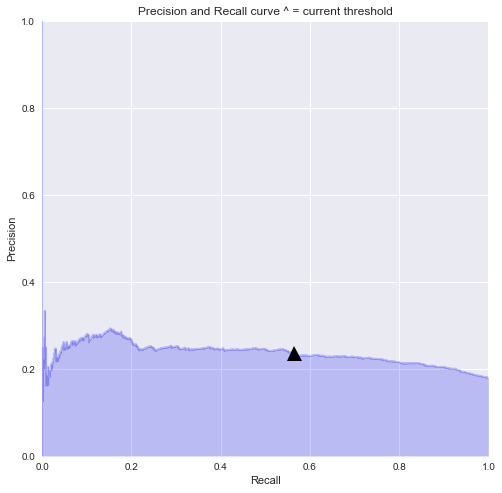

In [9]:
lr= LogisticRegression(**bestC)
lr.fit(dfX2,dfY2)
y_scores = lr.predict_proba(X_test)[:, 1]
p,r,threshold = precision_recall_curve(y_test,y_scores)
precision_recall_threshold(y_scores ,p, r, threshold, bestTLR)
y_scores = adjusted_classes(y_scores,bestTLR)
print('Threshold:',str(bestTLR))
print(pd.DataFrame(confusion_matrix(y_test, y_scores),
                    columns=['pred_neg', 'pred_pos'], 
                    index=['neg', 'pos']))
print(metrics.f1_score(y_test,y_scores))
print(metrics.average_precision_score(y_test,y_scores))

Randm Forest Threshold: 0.13894736842105262
     pred_neg  pred_pos
neg       965      1649
pos       134       439
0.3299511461856445
0.20312666538670973


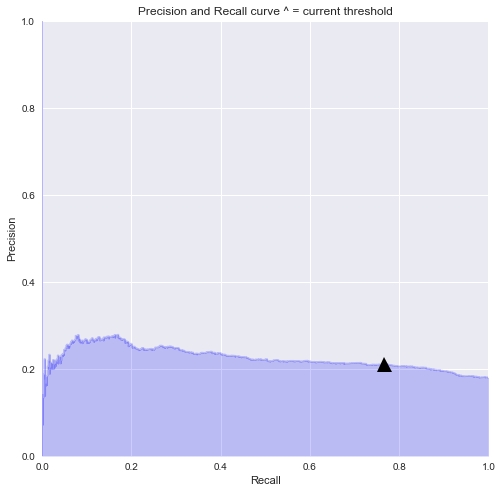

In [10]:
rf= RandomForestClassifier(n_estimators=1000, random_state=42, **bestL)
rf.fit(dfX2,dfY2)
y_scores = rf.predict_proba(X_test)[:, 1]
p,r,threshold = precision_recall_curve(y_test,y_scores)
precision_recall_threshold(y_scores ,p, r, threshold, bestTRFR)
y_scores = adjusted_classes(y_scores,bestTRFR)
print('Randm Forest Threshold:',str(bestTRFR))
print(pd.DataFrame(confusion_matrix(y_test, y_scores),
                    columns=['pred_neg', 'pred_pos'], 
                    index=['neg', 'pos']))
print(metrics.f1_score(y_test,y_scores))
print(metrics.average_precision_score(y_test,y_scores))

Threshold: 0.37105263157894736
     pred_neg  pred_pos
neg      1087      1527
pos       198       375
0.303030303030303
0.19115938420805004


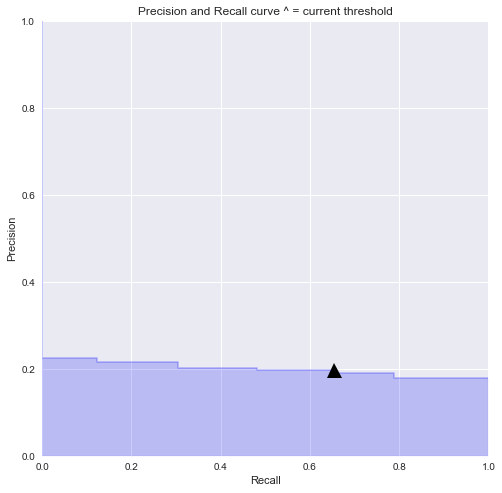

In [11]:
kn= KNeighborsClassifier(**bestK)
kn.fit(dfX2,dfY2)
y_scores = kn.predict_proba(X_test)[:, 1]
p,r,threshold = precision_recall_curve(y_test,y_scores)
precision_recall_threshold(y_scores ,p, r, threshold, bestTKNN)
y_scores = adjusted_classes(y_scores,bestTKNN)
print('Threshold:',str(bestTKNN))
print(pd.DataFrame(confusion_matrix(y_test, y_scores),
                    columns=['pred_neg', 'pred_pos'], 
                    index=['neg', 'pos']))
print(metrics.f1_score(y_test,y_scores))
print(metrics.average_precision_score(y_test,y_scores))

In [12]:
for x,y in sorted(zip(list(rf.feature_importances_), X_test.columns.tolist()), reverse =True):
    print(round(x,3),y)

0.137 Age
0.08 ?TourGeneration
0.052 ?TourContractGeneration
0.048 WeekdayOrWeekend
0.045 InState
0.032 HHIncomeRanges_70k to 89k
0.032 relationStatus
0.03 Year of TourDate
0.028 HHIncomeRanges_90k to 149k
0.024 BookingWindow_Inside 90 days
0.024 HHIncomeRanges_150k to 199k
0.021 BookingWindow_Inside Month
0.02 Programs (Budget)_(09) GL7 Inhouse
0.018 Programs (Budget)_(12) Outbound Telemarktng
0.018 BookingWindow_Inside Half Year
0.017 HHIncomeRanges_200k to 349k
0.017 AgentLine_Colorado
0.016 BookingWindow_Inside Year
0.015 BookingWindow_Inside 2 Days
0.014 Programs (Budget)_(06) GC8 Inhouse
0.014 Homeowner
0.014 Month of TourDate_February
0.013 BookingWindow_Inside Week
0.013 AgentLine_Breck
0.013 Month of TourDate_January
0.013 FirstGenVsOwner
0.013 Month of TourDate_March
0.012 TourSeason_Winter
0.012 TourSeason_Spring
0.011 HHIncomeRanges_350k to 500k
0.011 Month of TourDate_April
0.011 Programs (Budget)_(21) GTL In House
0.01 HHIncomeRanges_Under 70k
0.009 TourSeason_Summer
0.00